In [20]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.datasets import imdb

(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=100)

In [21]:
print(x_train_all.shape, y_train_all.shape)

(25000,) (25000,)


In [22]:
print(x_train_all[0])

[2, 2, 22, 2, 43, 2, 2, 2, 2, 65, 2, 2, 66, 2, 2, 2, 36, 2, 2, 25, 2, 43, 2, 2, 50, 2, 2, 2, 35, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 39, 2, 2, 2, 2, 2, 2, 38, 2, 2, 2, 2, 50, 2, 2, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 22, 71, 87, 2, 2, 43, 2, 38, 76, 2, 2, 2, 2, 22, 2, 2, 2, 2, 2, 2, 2, 2, 2, 62, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 66, 2, 33, 2, 2, 2, 2, 38, 2, 2, 25, 2, 51, 36, 2, 48, 25, 2, 33, 2, 22, 2, 2, 28, 77, 52, 2, 2, 2, 2, 82, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 36, 71, 43, 2, 2, 26, 2, 2, 46, 2, 2, 2, 2, 2, 2, 88, 2, 2, 2, 2, 98, 32, 2, 56, 26, 2, 2, 2, 2, 2, 2, 2, 22, 21, 2, 2, 26, 2, 2, 2, 30, 2, 2, 51, 36, 28, 2, 92, 25, 2, 2, 2, 65, 2, 38, 2, 88, 2, 2, 2, 2, 2, 2, 2, 2, 32, 2, 2, 2, 2, 2, 32]


In [23]:
for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    
print(x_train_all[0])

[22, 43, 65, 66, 36, 25, 43, 50, 35, 39, 38, 50, 22, 22, 71, 87, 43, 38, 76, 22, 62, 66, 33, 38, 25, 51, 36, 48, 25, 33, 22, 28, 77, 52, 82, 36, 71, 43, 26, 46, 88, 98, 32, 56, 26, 22, 21, 26, 30, 51, 36, 28, 92, 25, 65, 38, 88, 32, 32]


In [24]:
word_to_index = imdb.get_word_index()
word_to_index['movie']

17

In [25]:
index_to_word = {word_to_index[k] : k for k in word_to_index}

for w in x_train_all[0]:
    print(index_to_word[w - 3], end=' ')

film just story really they you just there an from so there film film were great just so much film would really at so you what they if you at film have been good also they were just are out because them all up are film but are be what they have don't you story so because all all 

In [26]:
print(len(x_train_all[0]), len(x_train_all[1]))

59 32


In [27]:
print(y_train_all[:10])

[1 0 0 1 0 0 1 0 1 0]


In [28]:
np.random.seed(42)
random_index = np.random.permutation(25000)

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [29]:
from tensorflow.keras.preprocessing import sequence

maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [30]:
print(x_train_seq.shape, x_val_seq.shape)

(20000, 100) (5000, 100)


In [31]:
print(x_train_seq[0])

[ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0
  0  0  0  0  0  0  0  0  0  0  0  0  0  0 35 40 27 28 40 22 83 31 85 45
 24 23 31 70 31 76 30 98 32 22 28 51 75 56 30 33 97 53 38 46 53 74 31 35
 23 34 22 58]


In [32]:
from tensorflow.keras.utils import to_categorical

x_train_onehot = to_categorical(x_train_seq)
x_val_onehot = to_categorical(x_val_seq)

In [33]:
print(x_train_onehot.shape)

(20000, 100, 100)


In [34]:
print(x_train_onehot.nbytes)

800000000


In [37]:
class RecurrentNetwork:
    
    def __init__(self, n_cells=10, batch_size=32, learning_rate=0.1):
        self.n_cells = n_cells #셀개수
        self.batch_size = batch_size #배치크기
        self.w1h = None #은닉상태에 대한 가중치
        self.w1x = None #입력에 대한 가중치
        self.b1 = None #순환층의 절편
        self.w2 = None #출력층의 가중치
        self.b2 = None #출력층의절편
        self.h = None #순환층의 활성화 출력
        self.losses = [] # 훈련손실
        self.val_losses = [] #검증손실
        self.lr = learning_rate #학습률
        
    def forpass(self, x):
        self.h = [np.zeros((x.shape[0], self.n_cells))]  #은닉상태 초기화
        #배치 차원과 타임 스텝 차원을 바꿉니다
        seq = np.swapaxes(x, 0, 1)
        #순환층의 선형식을 계산
        for x in seq:
            z1 = np.dot(x, self.w1x) + np.dot(self.h[-1], self.w1h) + self.b1
            h = np.tanh(z1)  #활성화 함수 적용
            self.h.append(h)  #역전파를 위해 은닉상태 저장
            z2 = np.dot(h, self.w2) + self.b2  #출력층의 선형식 계산
        return z2
    
    def backprop(self, x, err):
        m = len(x)  #샘플개수
        
        #출력층의 가중치와 절편에 댛나 그레이디언트를 계산함
        w2_grad = np.dot(self.h[-1].T, err) / m
        b2_grad = np.sum(err) / m
        #배치 차원과 타임 스텝 차원을 바꿉니다
        seq = np.swapaxes(x, 0, 1)
        
        w1h_grad = w1x_grad = b1_grad = 0
        #셀 직전까지 그레이디언트 계산
        err_to_cell = np.dot(err, self.w2.T) * (1 - self.h[-1] ** 2)
        #모든 타임 스텝을 거슬러가면서 그레이디언트를 전파함
        for x, h in zip(seq[::-1][:10], self.h[:-1][::-1][:10]):
            w1h_grad += np.dot(h.T, err_to_cell)
            w1x_grad += np.dot(x.T, err_to_cell)
            b1_grad += np.sum(err_to_cell, axis=0)
            #이전 타임 스텝의 셀 직전까지 그레이디언트를 계산함
            err_to_cell = np.dot(err_to_cell, self.w1h) * (1 - h ** 2)
        
        w1h_grad /= m
        w1x_grad /= m
        b1_grad /= m
        
        return w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad
    
    def sigmoid(self, z):
        a = 1 / (1+ np.exp(-z))   #시그모이드 계산
        return a
    
    def init_weights(self, n_features, n_classes):
        orth_init = tf.initializers.Orthogonal()
        glorot_init = tf.initializers.GlorotUniform()
        
        self.w1h = orth_init((self.n_cells, self.n_cells)).numpy()  #(셀 개수, 셀 개수)
        self.w1x = glorot_init((n_features, self.n_cells)).numpy()  #(특성 개수, 셀 개수)
        self.b1 = np.zeros(self.n_cells)                          # 은닉층의 크기
        self.w2 = glorot_init((self.n_cells, n_classes)).numpy() #(셀 개수, 클래스 개수)
        self.b2 = np.zeros(n_classes)
        
    
    def fit(self, x, y, epochs=100, x_val=None, y_val=None):
        y = y.reshape(-1, 1)
        y_val = y_val.reshape(-1, 1)
        np.random.seed(42)
        self.init_weights(x.shape[2], y.shape[1])    #은닉층과 출력층의 가중치를 초기화
        # epochs만큼 반복
        for i in range(epochs):
            print('에포크', i, end=' ')
            #제너레이터 함수에서 반환한 미니 배치를 순환함
            batch_losses = []
            for x_batch, y_batch in self.gen_batch(x, y):
                print('.', end=' ')
                a = self.training(x_batch, y_batch) ## 07장 트레이닝 메서드에서 x_val,y_val을 지움
                #안전한 로그 계산을 위해 클리핑함
                a = np.clip(a, 1e-10, 1-1e-10)
                #로그 손실과 규제 손실을 더하여 리스트에 추가함
                loss = np.mean(-(y_batch*np.log(a) + (1-y_batch)*np.log(1-a)))
                batch_losses.append(loss)
            print()
            self.losses.append(np.mean(batch_losses))
            #검증 세트에 대한 손실 계산
            self.update_val_loss(x_val, y_val)
            
    #미니 배치 제너레이터 함수
    def gen_batch(self, x, y):
        length = len(x)
        bins = length // self.batch_size #미니 배치 함수
        if length % self.batch_size:
            bins += 1                    #나누어 떨어지지 않을 때
        indexes = np.random.permutation(np.arange(len(x))) #인덱스 섞기
        x = x[indexes]
        y = y[indexes]
        for i in range(bins):
            start = self.batch_size * i
            end = self.batch_size * (i + 1)
            yield x[start:end], y[start:end]  #batch_size 만큼 슬라시이하여 변환
            
    
    def training(self, x, y):  #7장 트레이닝 메서드에서 x_val,y_val을 지움
        m = len(x)             #샘플 개수 저장
        z = self.forpass(x)    #정방향 계산 수행
        a = self.sigmoid(z)    #활성화 함수 적용
        err = -(y-a)           #오차 계산
        #오차를 역전파하여 그레이디언트를 계산함
        w1h_grad, w1x_grad, b1_grad, w2_grad, b2_grad = self.backprop(x, err)
        #셀의 가중치와 절편을 업데이트 함
        self.w1h -= self.lr * w1h_grad
        self.w1x -= self.lr * w1x_grad
        self.b1 -= self.lr * b1_grad
        #출력층의 가중치와 절편을 업데이트 함
        self.w2 -= self.lr * w2_grad
        self.b2 -= self.lr * b2_grad        
        return a
    
    def predict(self, x):
        z = self.forpass(x)   #정방향 계산 수행
        return z > 0         # 스텝 함수 적용
    
    def score(self, x, y):
        #예측과 타깃 열벡터를 비교하여 True의 비율 반환
        return np.mean(self.predict(x) == y.reshape(-1, 1))
    
    def update_val_loss(self, x_val, y_val):
        z = self.forpass(x_val)             #정방향 계산 수행
        a = self.sigmoid(z)                 #활성화 함수 적용
        a = np.clip(a, 1e-10, 1-1e-10)      #출력값 클리핑
        val_loss = np.mean(-(y_val * np.log(a) + (1-y_val) * np.log(1-a)))
        self.val_losses.append(val_loss)

In [38]:
rn = RecurrentNetwork(n_cells=32, batch_size=32, learning_rate=0.01)
rn.fit(x_train_onehot, y_train, epochs=20, x_val=x_val_onehot, y_val = y_val)

에포크 0 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

에포크 6 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 

에포크 12 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

에포크 18 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

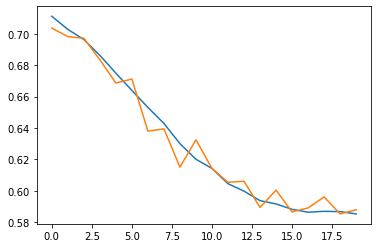

In [39]:
import matplotlib.pyplot as plt

plt.plot(rn.losses)
plt.plot(rn.val_losses)
plt.show()

In [40]:
rn.score(x_val_onehot, y_val)

0.6924

In [42]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

In [43]:
model = Sequential()

model.add(SimpleRNN(32, input_shape=(100,100)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 32)                4256      
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 4,289
Trainable params: 4,289
Non-trainable params: 0
_________________________________________________________________


In [45]:
model.compile(optimizer='sgd', loss= 'binary_crossentropy', metrics=['accuracy'])

history = model.fit(x_train_onehot, y_train, epochs=20, batch_size=32, validation_data=(x_val_onehot, y_val))

Epoch 1/20
625/625 [==============================] - 8s 12ms/step - loss: 0.7022 - accuracy: 0.5030 - val_loss: 0.6935 - val_accuracy: 0.5264
Epoch 2/20
625/625 [==============================] - 8s 12ms/step - loss: 0.6922 - accuracy: 0.5239 - val_loss: 0.6842 - val_accuracy: 0.5586
Epoch 3/20
625/625 [==============================] - 8s 12ms/step - loss: 0.6803 - accuracy: 0.5657 - val_loss: 0.6640 - val_accuracy: 0.6066
Epoch 4/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6635 - accuracy: 0.6002 - val_loss: 0.6409 - val_accuracy: 0.6428
Epoch 5/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6813 - accuracy: 0.5523 - val_loss: 0.6936 - val_accuracy: 0.5142
Epoch 6/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6927 - accuracy: 0.5203 - val_loss: 0.6926 - val_accuracy: 0.5164
Epoch 7/20
625/625 [==============================] - 7s 12ms/step - loss: 0.6918 - accuracy: 0.5222 - val_loss: 0.6922 - val_accuracy: 0.5218

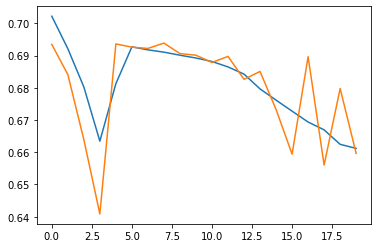

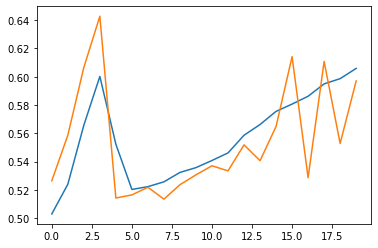

In [47]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [48]:
loss, accuracy = model.evaluate(x_val_onehot, y_val, verbose=0)

In [49]:
print(accuracy)

0.597000002861023


In [50]:
from tensorflow.keras.layers import Embedding

In [51]:
(x_train_all, y_train_all), (x_test, y_test) = imdb.load_data(skip_top=20, num_words=1000)

for i in range(len(x_train_all)):
    x_train_all[i] = [w for w in x_train_all[i] if w > 2]
    

x_train = x_train_all[random_index[:20000]]
y_train = y_train_all[random_index[:20000]]
x_val = x_train_all[random_index[20000:]]
y_val = y_train_all[random_index[20000:]]

In [52]:
maxlen=100
x_train_seq = sequence.pad_sequences(x_train, maxlen=maxlen)
x_val_seq = sequence.pad_sequences(x_val, maxlen=maxlen)

In [53]:
model_ebd = Sequential()

model_ebd.add(Embedding(1000, 32))

In [54]:
model_ebd.add(SimpleRNN(8))
model_ebd.add(Dense(1, activation='sigmoid'))

model_ebd.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 32)          32000     
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 8)                 328       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 9         
Total params: 32,337
Trainable params: 32,337
Non-trainable params: 0
_________________________________________________________________


In [56]:
model_ebd.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_ebd.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 9s 15ms/step - loss: 0.5881 - accuracy: 0.6807 - val_loss: 0.5151 - val_accuracy: 0.7598
Epoch 2/10
625/625 [==============================] - 9s 15ms/step - loss: 0.5261 - accuracy: 0.7530 - val_loss: 0.5121 - val_accuracy: 0.7628
Epoch 3/10
625/625 [==============================] - 9s 15ms/step - loss: 0.4601 - accuracy: 0.7941 - val_loss: 0.5162 - val_accuracy: 0.7672
Epoch 4/10
625/625 [==============================] - 9s 15ms/step - loss: 0.4510 - accuracy: 0.7999 - val_loss: 0.5055 - val_accuracy: 0.7676
Epoch 5/10
625/625 [==============================] - 9s 15ms/step - loss: 0.4306 - accuracy: 0.8140 - val_loss: 0.4970 - val_accuracy: 0.7824
Epoch 6/10
625/625 [==============================] - 9s 15ms/step - loss: 0.4184 - accuracy: 0.8224 - val_loss: 0.5009 - val_accuracy: 0.7766
Epoch 7/10
625/625 [==============================] - 9s 14ms/step - loss: 0.3984 - accuracy: 0.8328 - val_loss: 0.5008 - val_accuracy: 0.7778

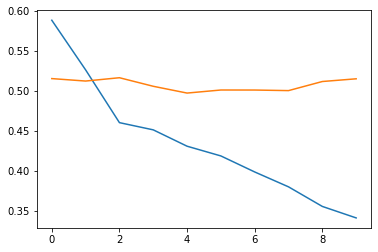

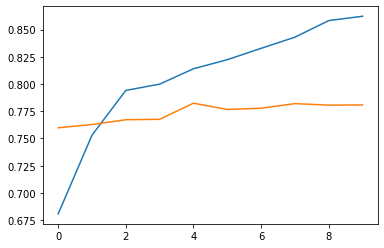

In [57]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [58]:
loss, accuracy = model_ebd.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.7807999849319458


In [59]:
from tensorflow.keras.layers import LSTM

model_lstm = Sequential()

model_lstm.add(Embedding(1000, 32))
model_lstm.add(LSTM(8))
model_lstm.add(Dense(1, activation='sigmoid'))

model_lstm.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 32)          32000     
_________________________________________________________________
lstm (LSTM)                  (None, 8)                 1312      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 33,321
Trainable params: 33,321
Non-trainable params: 0
_________________________________________________________________


In [60]:
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
history = model_lstm.fit(x_train_seq, y_train, epochs=10, batch_size=32, validation_data=(x_val_seq, y_val))

Epoch 1/10
625/625 [==============================] - 12s 20ms/step - loss: 0.4361 - accuracy: 0.8038 - val_loss: 0.3749 - val_accuracy: 0.8446
Epoch 2/10
625/625 [==============================] - 12s 19ms/step - loss: 0.3311 - accuracy: 0.8609 - val_loss: 0.3565 - val_accuracy: 0.8388
Epoch 3/10
625/625 [==============================] - 12s 20ms/step - loss: 0.3072 - accuracy: 0.8695 - val_loss: 0.3583 - val_accuracy: 0.8392
Epoch 4/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2952 - accuracy: 0.8740 - val_loss: 0.3581 - val_accuracy: 0.8432
Epoch 5/10
625/625 [==============================] - 12s 20ms/step - loss: 0.2804 - accuracy: 0.8814 - val_loss: 0.3679 - val_accuracy: 0.8404
Epoch 6/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2704 - accuracy: 0.8871 - val_loss: 0.3961 - val_accuracy: 0.8356
Epoch 7/10
625/625 [==============================] - 12s 19ms/step - loss: 0.2598 - accuracy: 0.8906 - val_loss: 0.3747 - val_accuracy:

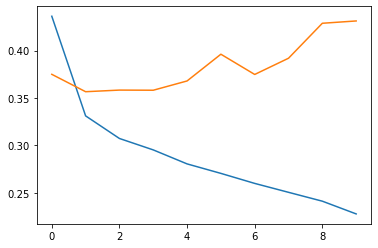

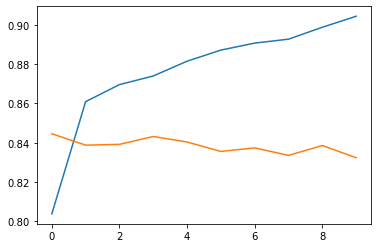

In [61]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.show()


plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.show()

In [62]:
loss, accuracy = model_lstm.evaluate(x_val_seq, y_val, verbose=0)
print(accuracy)

0.8324000239372253
